In [44]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [45]:
# Load all data
folder = "feature-importance-analysis"

# Load clean
df_all = pd.read_csv(f"{folder}/ravdess_audio_features_all.csv")
noise_levels = [0.005, 0.01, 0.02, 0.05, 0.1]

for nl in noise_levels:
    df_noise = pd.read_csv(f"{folder}/ravdess_features_noisy_{nl}.csv")
    df_all = pd.concat([df_all, df_noise], ignore_index=True)

features = df_all.columns[:-1]
X = df_all[features]  # no .values
y = df_all["Emotion"].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
import joblib
joblib.dump(scaler, 'Models/feature_scaler.pkl')


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
class EmotionNet3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmotionNet3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),           
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionNet3(X.shape[1], len(label_encoder.classes_)).to(device)


In [47]:
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation on validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            predicted = preds.argmax(dim=1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    
    val_acc = correct / total
    avg_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")



Epoch 01 | Loss: 1.8927 | Val Acc: 0.3472
Epoch 02 | Loss: 1.7489 | Val Acc: 0.3929
Epoch 03 | Loss: 1.6903 | Val Acc: 0.3877
Epoch 04 | Loss: 1.6505 | Val Acc: 0.4039
Epoch 05 | Loss: 1.6306 | Val Acc: 0.4144
Epoch 06 | Loss: 1.6016 | Val Acc: 0.4167
Epoch 07 | Loss: 1.5754 | Val Acc: 0.4398
Epoch 08 | Loss: 1.5570 | Val Acc: 0.4537
Epoch 09 | Loss: 1.5502 | Val Acc: 0.4514
Epoch 10 | Loss: 1.5236 | Val Acc: 0.4491
Epoch 11 | Loss: 1.5134 | Val Acc: 0.4618
Epoch 12 | Loss: 1.4986 | Val Acc: 0.4520
Epoch 13 | Loss: 1.4880 | Val Acc: 0.4682
Epoch 14 | Loss: 1.4625 | Val Acc: 0.4664
Epoch 15 | Loss: 1.4529 | Val Acc: 0.4653
Epoch 16 | Loss: 1.4480 | Val Acc: 0.4688
Epoch 17 | Loss: 1.4566 | Val Acc: 0.4757
Epoch 18 | Loss: 1.4169 | Val Acc: 0.4884
Epoch 19 | Loss: 1.4182 | Val Acc: 0.4797
Epoch 20 | Loss: 1.4209 | Val Acc: 0.4670
Epoch 21 | Loss: 1.3895 | Val Acc: 0.4751
Epoch 22 | Loss: 1.3904 | Val Acc: 0.4844
Epoch 23 | Loss: 1.3838 | Val Acc: 0.4838
Epoch 24 | Loss: 1.3631 | Val Acc:

In [48]:
def evaluate_model(X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
        preds = model(X_test_tensor)
        predicted = preds.argmax(dim=1)
        accuracy = (predicted == y_test_tensor).float().mean().item()
    return accuracy


In [49]:
accuracies_nn = []

# Evaluate on clean
# Clean test set
df_clean = pd.read_csv(f"{folder}/ravdess_audio_features_all.csv")
X_clean = scaler.transform(df_clean[features])
y_clean = label_encoder.transform(df_clean["Emotion"])
_, X_test_clean, _, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42)
acc_clean = evaluate_model(X_test_clean, y_test_clean)
accuracies_nn.append(acc_clean)

# Evaluate on noisy levels
for nl in noise_levels:
    # Noisy test sets
    df_noise = pd.read_csv(f"{folder}/ravdess_features_noisy_{nl}.csv")
    X_noise = scaler.transform(df_noise[features])
    y_noise = label_encoder.transform(df_noise["Emotion"])
    _, X_test_noise, _, y_test_noise = train_test_split(X_noise, y_noise, test_size=0.2, stratify=y_noise, random_state=42)
    acc = evaluate_model(X_test_noise, y_test_noise)
    accuracies_nn.append(acc)


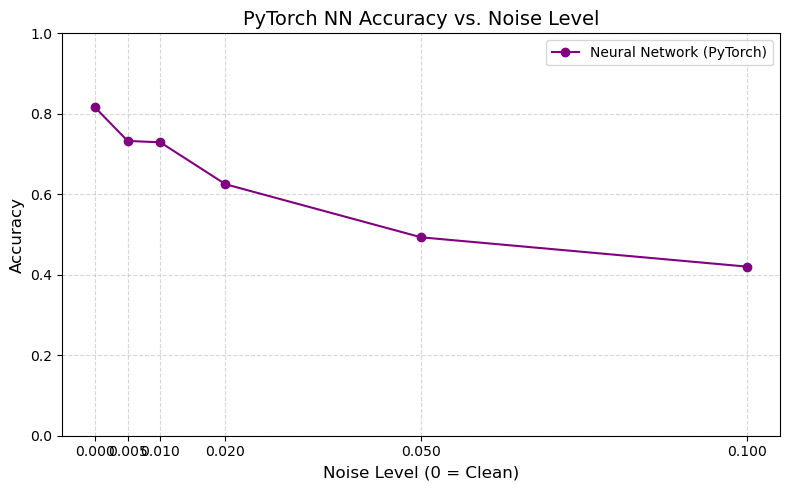

In [50]:
noise_levels_full = [0] + noise_levels

plt.figure(figsize=(8, 5))
plt.plot(noise_levels_full, accuracies_nn, marker='o', color='purple', label='Neural Network (PyTorch)')
plt.title("PyTorch NN Accuracy vs. Noise Level", fontsize=14)
plt.xlabel("Noise Level (0 = Clean)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.xticks(noise_levels_full, [f"{n:.3f}" for n in noise_levels_full])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Testing on custom data

In [51]:
import os
import subprocess

input_folder = "Custom_audio"
output_folder = "converted_wavs"
os.makedirs(output_folder, exist_ok=True)

for file in os.listdir(input_folder):
    if file.endswith(".m4a"):
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, file.replace(".m4a", ".wav"))
        subprocess.run(["ffmpeg", "-y", "-i", input_path, output_path])
        print(f"Converted: {file} → {output_path}")


Converted: Dog anger.m4a → converted_wavs/Dog anger.wav
Converted: Kids drama sad.m4a → converted_wavs/Kids drama sad.wav


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 16.0.6
  configuration: --prefix=/opt/anaconda3 --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1705437067053/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-libass --enable-pthreads --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --pkg-con

In [52]:
torch.save(model.state_dict(), "Models/emotion_model3.pt")
print("Model exported to 'Models/emotion_model3.pt'")



Model exported to 'Models/emotion_model3.pt'


In [53]:
print(X.shape[1])
print(len(label_encoder.classes_))

38
8


In [54]:
print(label_encoder.classes_)


['Angry' 'Calm' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad' 'Surprised']
